# **Newton Method with Finite Differences Overview**

The basic idea behind the Newton Method is the usage of a steplength 
$$ p_k^N = -(∇^2f(x_k))^{-1}∇f(x_k) $$

So that at each step we compute the new poin $ x_{k+1} = x_k + α_{k}p_k $
Where the value of $ α_k $ is computed  with a linsearch [satisfaction of the Armijo condition $ f(x_k + αp_k) ≤ f(x_k) + c_1α∇f(x_k)^Tp_k $, $ c_1 = 10^{-4} $ ]
The computation of the Gradient and the Hessian could be expensive, for this reason we proceed with the estimation of the 2 with the finite difference method

$$ \frac{\partial f}{\partial x_i}(x) = \frac{\partial f}{\partial x_i}(x_1, …,x_n) ≃ \frac{f(x + he_i) - f(x)}{h}$$

for the forward difference

$$ \frac{\partial f}{\partial x_i}(x) = \frac{\partial f}{\partial x_i}(x_1, …,x_n) ≃ \frac{f(x) - f(x - he_i)}{h}$$

for the backward difference and

$$ \frac{\partial f}{\partial x_i}(x) = \frac{\partial f}{\partial x_i}(x_1, …,x_n) ≃ \frac{f(x + he_i) - f(x - he_i)}{2h}$$

for the central difference

$$ h ≃ \sqrt{𝛆_m}|{x_0}|$$

with $ 𝛆_m $ the Machine precision

The second order Derivative can be approximated:

$$ f''(x_0) = \frac{f(x_0 + h) - 2f(x_0) + f(x_0 - h)}{h^2}  $$

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import cg

# **1 - Newton Method Implementation**

In [85]:
def findiff_grad(f, x, h, type = 'fw'):
  gradfx = np.zeros(len(x))

  if type == 'c':
    for i in range(len(x)):
      xh_plus = x.copy()
      xh_minus = x.copy()
      xh_plus[i] = xh_plus[i] + h
      xh_minus[i] = xh_minus[i] - h
      gradfx[i] = (f(xh_plus) - f(xh_minus))/(2*h)
  
  else:
    for i in range(len(x)):
      xh = x.copy()
      xh[i] = xh[i] + h
      gradfx[i] = (f(xh) - f(x))/h

  return gradfx


In [145]:
def findiff_Hess(f, x, h):
  Hessfx = np.zeros((len(x), len(x)))

  for j in range(len(x)):

    xh_plus = x.copy()
    xh_minus = x.copy()
    xh_plus[j] = xh_plus[j] + h
    xh_minus[j] = xh_minus[j] - h
    Hessfx[j, j] = (f(xh_plus) - 2*f(x) + f(xh_minus))/(h**2)

    for i in range(j+1, len(x)):
      xh_plus_ij = x.copy()
      xh_plus_ij[[i, j]] = xh_plus_ij[[i, j]] + h
      xh_plus_i = x.copy()
      xh_plus_i[i] = xh_plus_i[i] + h
      xh_plus_j = x.copy()
      xh_plus_j[j] = xh_plus_j[j] + h
      Hessfx[i, j] = (f(xh_plus_ij) - f(xh_plus_i) - f(xh_plus_j) + f(x))/(h**2)
      Hessfx[j, i] = Hessfx[i, j]
  
  return Hessfx



In [169]:
def findiff_J(F, x, h, type = 'fw'):
  JFx = np.zeros((len(F(x)), len(x)))
  print("sono qui")
  for i in range(len(x)):
    xh_plus = x.copy()
    xh_minus = x.copy()
    xh_plus[i] = xh_plus[i] + h
    xh_minus[i] = xh_minus[i] - h*(type == 'c')
    JFx[:, i] = (F(xh_plus) - F(xh_minus))/((1 + (type == 'c'))*h)

  print(JFx)
  return JFx


In [236]:

class NewtonGradientDescent:
  def __init__(self, kmax = 1000, tolgrad = 10**(-12), c1 = 10**(-4), rho = 0.8, btmax = 50, pcg_maxit = 50):
    self.kmax = kmax
    self.tolgrad = tolgrad
    self.c1 = c1
    self.rho = rho
    self.btmax = btmax
    self.pcg_maxit = pcg_maxit
    
  
  def min_search(self, x0, f, gradf = None, Hessf = None, FDgrad = None, FDHess = None, h = None):
    
    if FDgrad != None:
      
      gradf = lambda x: findiff_grad(f, x, h, FDgrad)
      
      if FDHess == 'c':
        Hessf = lambda x: findiff_Hess(f, x, np.sqrt(h))
      elif FDHess == 'MF':
        Hessf_pk = lambda x, p: (gradf(x+h*p) - gradf(x))/h
      else:
        Hessf = lambda x: findiff_Hess(f, x, np.sqrt(h))
    
    else:
      if FDHess == 'c':
        Hessf = lambda x: findiff_Hess(f, x, np.sqrt(h))
      elif FDHess == 'Jfw':
        Hessf = lambda x: findiff_J(gradf, x, h, 'fw')
      elif FDHess == 'Jc':
        Hessf = lambda x: findiff_J(gradf, x, h, 'c')
      elif FDHess == 'MF':
        Hessf_pk = lambda x, p: (gradf(x+h*p) - gradf(x))/h
      

    if h == None:
      h = np.sqrt(np.finfo(float).eps)*np.linalg.norm(x0)
    
    farmijo = lambda fk, alpha, gradfk, pk: fk + self.c1*alpha*np.dot(gradfk.T, pk)

    xseq = np.zeros((len(x0), self.kmax))
    btseq = np.zeros((1, self.kmax))
    xk = x0.copy()
    fk = f(xk)
    k = 0
    gradfk = gradf(xk)
    gradfk_norm = np.linalg.norm(gradfk)

    while (k < self.kmax) and (gradfk_norm >= self.tolgrad):
      
      xseq[:, k] = xk

      if FDHess == 'MF':
        Hessfk = lambda p: Hessf_pk(xk, p)
        pk, _ = cg(Hessf_pk, -gradfk.T, tol = self.tolgrad, maxiter = self.pcg_maxit)
      
      else:
        pk, _ = cg(Hessf(xk), -gradfk.T, tol = self.tolgrad, maxiter = self.pcg_maxit)

      alpha = 1
      xnew = xk + alpha*pk

      fnew = f(xnew)

      bt = 0
      
      while (bt < self.btmax):
        if f(xnew) <= farmijo(fk, alpha, gradfk, pk):
         break

        alpha = self.rho*alpha
        xnew = xk+alpha*pk
        fnew = f(xnew)
        bt += 1

      xk = xnew
      fk = fnew
      gradfk = gradf(xk)
      gradfk_norm = np.linalg.norm(gradfk)
      btseq[0, k] = bt

      k += 1

    xseq = xseq[:, :k]
    btseq = btseq[:k]

    return xk, fk, gradfk_norm, k, xseq, btseq



In [260]:
f1 = lambda x: x[0]**2 + 4*x[1]**2 + 5
f2 = lambda x: 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2
f3 = lambda x: (x[0]**2 + x[1]-11)**2 + (x[0] + x[1]**2 -7)**2

FDgrad = 'fw'
FDHess = 'c'

ngd = NewtonGradientDescent()

x0 = np.array([-5, -5], dtype = float).T

h = np.sqrt(np.finfo(float).eps)*np.linalg.norm(x0)

In [272]:
%%time
print("##### NEWTON: START f1 #####")

xk, fk, gradfk_norm, k, xseq, btseq = ngd.min_search(x0, f1, FDgrad = FDgrad, FDHess = FDHess, h = h)

print(f"\nk={k}\nxk={xk}\nfk={fk}\n")
print("##### END #####\n")

##### NEWTON: START f1 #####

k=9
xk=[-5.16191850e-08 -5.26835594e-08]
fk=5.000000000000014

##### END #####

CPU times: user 7.07 ms, sys: 969 µs, total: 8.04 ms
Wall time: 9.04 ms


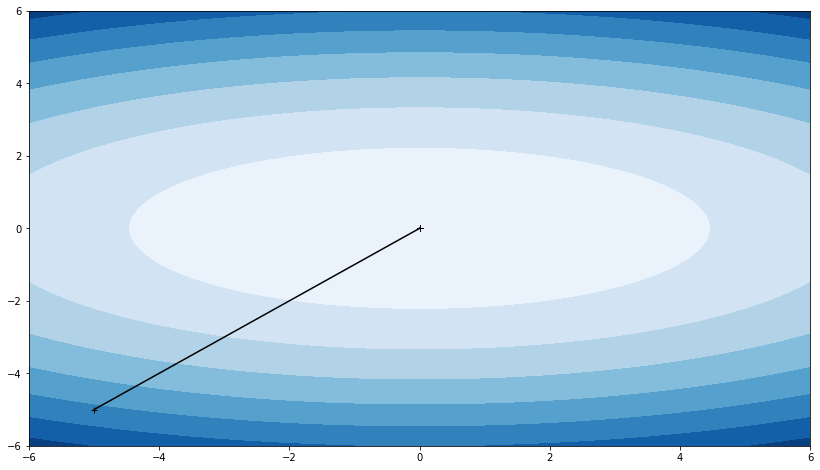

In [273]:
X, Y = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))

Z = X**2 + 4*Y**2 + 5

plt.figure(figsize = (14, 8))
plt.contourf(X, Y, Z, cmap = 'Blues')
plt.plot(xseq[0, :], xseq[1, :], marker = '+', color = 'black')
plt.show()

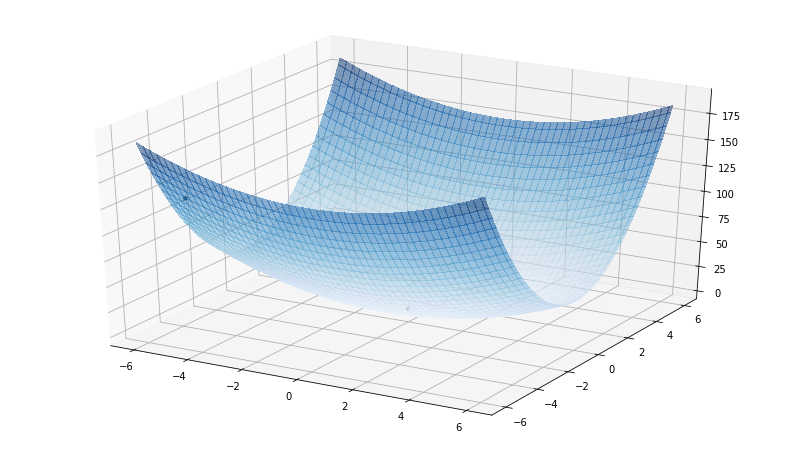

In [274]:
f1_s = lambda x: x[0, :]**2 + 4*x[1, :]**2 + 5
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (14, 8))
surf = ax.plot_surface(X, Y, Z, cmap='Blues',
                       linewidth=0.1, antialiased=False, alpha = 0.5)
ax.scatter(xseq[0, :], xseq[1, :], f1_s(xseq), marker = '*', color = 'black')
plt.show()

In [277]:
%%time
print("##### NEWTON: START f2 #####")
print()

xk, fk, gradfk_norm, k, xseq, btseq = ngd.min_search(x0, f2, FDgrad = FDgrad, FDHess = FDHess, h = h)

print(f"\nk={k}\nxk={xk}\nfk={fk}\n")
print("##### END #####\n")


##### NEWTON: START f2 #####


k=1000
xk=[0.99997566 0.99995128]
fk=5.926765381184593e-10

##### END #####

CPU times: user 920 ms, sys: 7.83 ms, total: 928 ms
Wall time: 925 ms


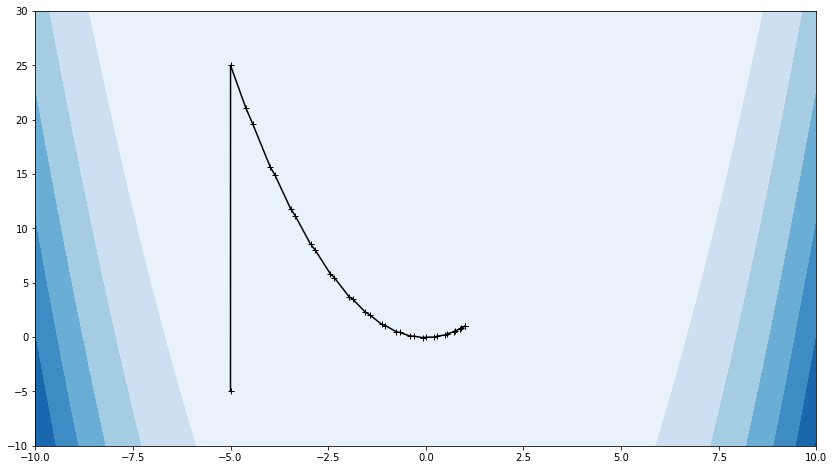

In [279]:
X, Y = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 30, 500))

Z = 100*(Y - X**2)**2 + (1 - X)**2

plt.figure(figsize = (14, 8))
plt.contourf(X, Y, Z, cmap = 'Blues')
plt.plot(xseq[0, :], xseq[1, :], marker = '+', color = 'black')
plt.show()

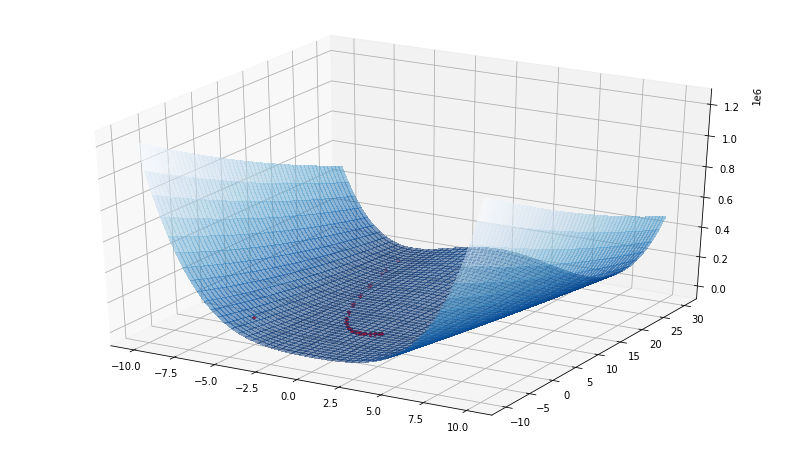

In [282]:
f2_s = lambda x: 100*(x[1, :] - x[0, :]**2)**2 + (1 - x[0, :])**2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (14, 8))
surf = ax.plot_surface(X, Y, Z, cmap='Blues_r',
                       linewidth=0.1, antialiased=False, alpha = 0.5)
ax.scatter(xseq[0, :], xseq[1, :], f2_s(xseq), marker = '+', color = 'red')
plt.show()

In [261]:
%%time
print("##### NEWTON: START f3 #####")
print()

xk, fk, gradfk_norm, k, xseq, btseq = ngd.min_search(x0, f3, FDgrad = FDgrad, FDHess = FDHess, h = h)

print(f"\nk={k}\nxk={xk}\nfk={fk}\n")
print("##### END #####\n")


##### NEWTON: START f3 #####


k=6
xk=[-3.77931032 -3.28318607]
fk=3.927651220880274e-13

##### END #####

CPU times: user 7.08 ms, sys: 0 ns, total: 7.08 ms
Wall time: 7.5 ms


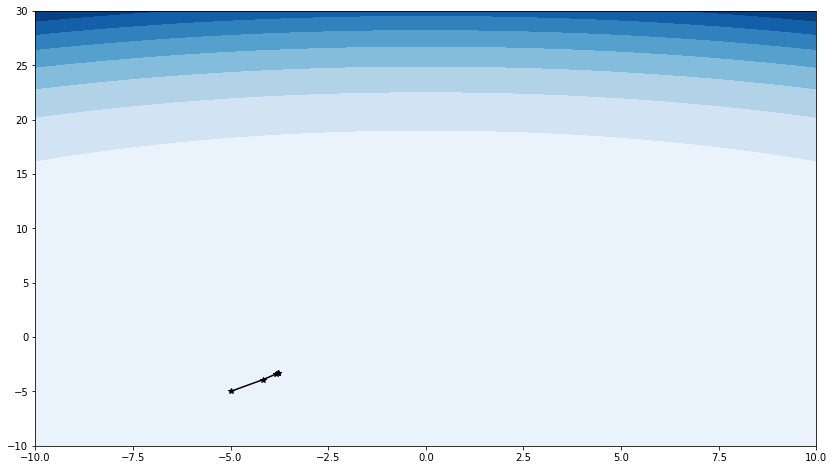

In [262]:
X, Y = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 30, 500))

Z = (X**2 + Y**2 - 11)**2 + (X**2 + Y**2 - 7)**2

plt.figure(figsize = (14, 8))
plt.contourf(X, Y, Z, cmap = 'Blues')
plt.plot(xseq[0, :], xseq[1, :], marker = '*', color = 'black')
plt.show()

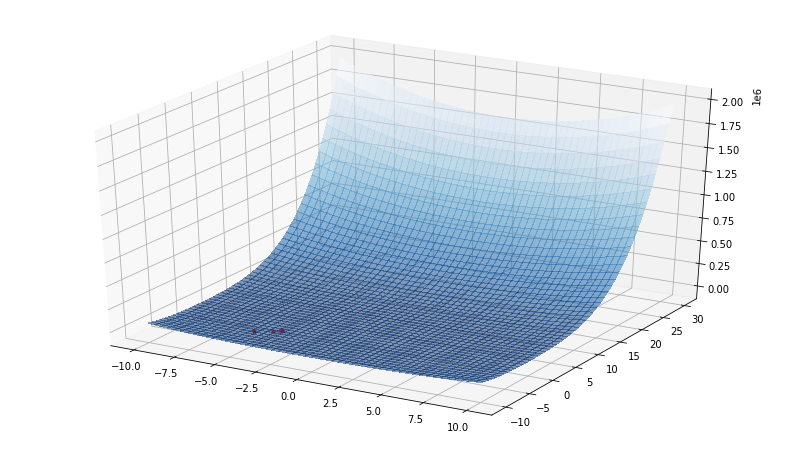

In [264]:
f3_s = lambda x: (x[0, :]**2 + x[1, :]-11)**2 + (x[0, :] + x[1, :]**2 -7)**2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (14, 8))
surf = ax.plot_surface(X, Y, Z, cmap='Blues_r',
                       linewidth=0.1, antialiased=False, alpha = 0.5)
ax.scatter(xseq[0, :], xseq[1, :], f3_s(xseq), marker = '*', color = 'red')
plt.show()